# Reason for this test #

### Documentation of an idea ###

The point of adding the last fcost constraint expression, which is trivial anyways because it comes from <b>1</b> - <b>2</b> - <b>3</b>, is that these contraints then can be changed easily when changing the destination node. Just change the RHS of the constraint equations, that is subtract 1 or 0 accordingly.

In [1]:
from pyqubo import Array,Constraint,Placeholder

In [2]:
edges = [(1,2),(1,3),(2,3),(2,4),(3,4), (4,1)]
weights = [5,8,2,7,4,3] 
x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') 

In [3]:
print(x.shape)
print(x)
y = (4*x[0]+x[1])
print(y)

(6,)
Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]'), Binary('x[4]'), Binary('x[5]')])
((4.000000 * Binary('x[0]')) + Binary('x[1]'))


In [4]:
# model = ((x[0] + x[1] - 1)).compile()
# print(model.to_qubo())

In [5]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

p = 27 # chosen arbitrarily. It represents the penalty for the constraints. Also another parameter that can be varied

## Constraints ##
fcost += p*((x[0] + x[1] - x[5] - 1)**2) 
fcost += p*((x[0] - x[2] - x[3] - 0)**2)
fcost += p*((x[1] + x[2] - x[4] - 0)**2)
fcost += p*((x[3] + x[4] - x[5] - 1)**2)

In [6]:
model = fcost.compile()

In [7]:
print(model.to_qubo())

({('x[5]', 'x[4]'): -54.0, ('x[2]', 'x[2]'): 56.0, ('x[4]', 'x[2]'): -54.0, ('x[5]', 'x[0]'): -54.0, ('x[1]', 'x[0]'): 54.0, ('x[5]', 'x[1]'): -54.0, ('x[3]', 'x[4]'): 54.0, ('x[1]', 'x[2]'): 54.0, ('x[3]', 'x[0]'): -54.0, ('x[2]', 'x[0]'): -54.0, ('x[5]', 'x[3]'): -54.0, ('x[3]', 'x[3]'): 7.0, ('x[4]', 'x[4]'): 4.0, ('x[3]', 'x[2]'): 54.0, ('x[4]', 'x[1]'): -54.0, ('x[5]', 'x[5]'): 165.0, ('x[0]', 'x[0]'): 5.0, ('x[1]', 'x[1]'): 8.0}, 54.0)


In [8]:
linear, quadratic, offset = model.to_ising()
print("Linear Coefficients", linear)
print("Quadratic Coefficients", quadratic)

## The objective function is then made from these linear and quadratic terms ##
## The objective function represents the Problem Hamiltonian Hp ##

Linear Coefficients {'x[0]': -24.5, 'x[1]': 4.0, 'x[2]': 28.0, 'x[3]': 3.5, 'x[4]': -25.0, 'x[5]': 28.5}
Quadratic Coefficients {('x[0]', 'x[1]'): 13.5, ('x[2]', 'x[3]'): 13.5, ('x[0]', 'x[2]'): -13.5, ('x[1]', 'x[5]'): -13.5, ('x[3]', 'x[4]'): 13.5, ('x[0]', 'x[3]'): -13.5, ('x[0]', 'x[5]'): -13.5, ('x[1]', 'x[2]'): 13.5, ('x[1]', 'x[4]'): -13.5, ('x[2]', 'x[4]'): -13.5, ('x[3]', 'x[5]'): -13.5, ('x[4]', 'x[5]'): -13.5}


### So making these changes to the fcost constraint expressions did not have any change to the QUBO model generated, which checks out ###

## Modified Network ##

### Node 2 is the destination node ###

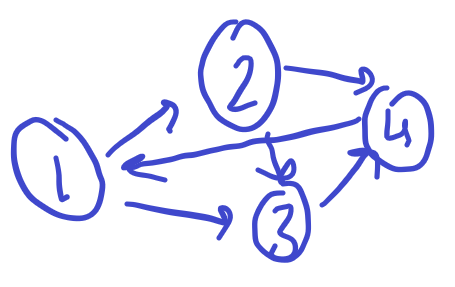

In [9]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

In [10]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [11]:
def create_circuit(beta, gamma):
    ## initializing the initial qubit state with H gates ##
    circuit = Circuit()
    n_qubits = len(edges)

    for qubit in range(n_qubits):
        circuit.h(qubit)
    
    ## Implementing the problem Hamiltonian ##
    for qubit in range(n_qubits):
        linear_coeff = linear.get('x['+str(qubit)+']')
        circuit = circuit.rz(qubit, -1*linear_coeff)

    #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
    for i in range(len(quadratic)):
        qubit_1 = int(list(quadratic.keys())[i][0][2])
        qubit_2 = int(list(quadratic.keys())[i][1][2])

        quadratic_coeff = quadratic.get(('x['+str(qubit_1)+']', 'x['+str(qubit_2)+']'))

        circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)
    
    ## Implementing the Mixer Hamiltonian ##
    for qubit in range(n_qubits):
        circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle
        
    return circuit

* <b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

In [12]:
## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
## cost values over all states that have occurred ##
def compute_expectation(counts, shots):
    
    expectation = 0
    sum = 0
    states = list(counts.keys())
    for i in range(len(states)):
        state = states[i] # string variable of the current qubit states
        state_cost = 0
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]
        
        expectation = expectation + state_cost*counts.get(state)
        
    expectation /= 1000
    # print(expectation)
    return expectation

In [13]:
## Now we measure the circuit ##
def expectation_execute_circuit(param):
    ## Set up the device to run the circuit
    device = LocalSimulator()
    
    ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
    beta = param[0]
    gamma = param[1]
    
    circuit = create_circuit(beta, gamma)
    
    shots = 5000
    result = device.run(circuit, shots).result()
    counts = result.measurement_counts
    
    return compute_expectation(counts, shots)    

In [18]:
## Classical Optimizer ##

from scipy.optimize import minimize

res = minimize(expectation_execute_circuit,
               [1.0, 1.0],
               method='COBYLA')
print(res)

     fun: 60.318
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([0.99489173, 0.92842695])


## Analyzing the Results

In [19]:
beta = res.get('x')[0]
gamma = res.get('x')[1]
circuit = create_circuit(0.28517317, -5.05969577)

device = LocalSimulator()
result = device.run(circuit, shots = 1000).result()
counts = result.measurement_counts

print(counts)

# plot using Counter
#plt.bar(counts.keys(), counts.values())
#plt.xlabel('bitstrings')
#plt.ylabel('counts')

Counter({'111000': 48, '101010': 42, '001001': 40, '100100': 36, '110101': 36, '001110': 35, '100010': 35, '010111': 34, '110111': 32, '010010': 32, '101000': 31, '001000': 31, '111011': 27, '101111': 24, '001111': 23, '101100': 22, '010000': 20, '110110': 19, '001010': 19, '011010': 19, '000000': 18, '100110': 18, '100001': 18, '011101': 17, '000100': 17, '101011': 16, '110001': 16, '010101': 15, '011011': 14, '100111': 13, '111110': 13, '101101': 13, '111001': 13, '000111': 12, '001101': 12, '010100': 11, '101001': 11, '000110': 10, '010110': 10, '000010': 10, '001100': 9, '111101': 8, '001011': 8, '000101': 7, '110011': 7, '100011': 7, '010011': 7, '010001': 6, '111111': 6, '011100': 6, '011001': 6, '110100': 6, '110000': 5, '000011': 5, '100101': 4, '101110': 4, '100000': 4, '011111': 4, '110010': 3, '011000': 3, '111010': 2, '111100': 1})


In [16]:
print(weights)

[5, 8, 2, 7, 4, 3]


### So adding an outgoing path from Node 4 does change quite a lot, the probabilities are a lot less concrete than without the last path ###
Increasing the number of shots may help in the counts

Now lets try making Node 2 as the destination node

In [17]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

p = 27 # chosen arbitrarily. It represents the penalty for the constraints. Also another parameter that can be varied

## Modified Constraints for Node 2 as destination ##
fcost += p*((x[0] + x[1] - x[5] - 1)**2) 
fcost += p*((x[0] - x[2] - x[3] - 0)**2)
fcost += p*((x[1] + x[2] - x[4] - 1)**2)
fcost += p*((x[3] + x[4] - x[5] - 0)**2)

### Maybe an outgoing branch from the destination node screws up the calculations. Try removing an outgoing branch from 2 in the above example.

That would make it somewhat difficult to dynamically change constraints. So try making the cost of an outgoing branch from a destination node go to inifinity(make it very large).

<b>Changing Costs did not work</b>

Maybe try avoiding cycles in the network - which also didn't work